# Introduction

Search is a very broad term in artificial intelligence. What seems so intuitive to us as humans, such as finding an efficient route from city A to city B when looking at a map, is not so straightforward when we want a computer to do the same thing.

At very first glance, a simple thing such as search may seem irrelevant when we want to create artificial intelligence. It may seem boring, over-simplistic or useless to solve this problem, but it turns out that most of what's considered artificial intelligence today is per definition just a search problem and in fact, it is solved by one of these simple search algorithms - gradient descent - which is just as simple as any of its relatives, be it from the informed or uninformed, global or local category.

::: {.callout-note}
This article is based on the chapter about uninformed search in "Artificial Intelligence: A Modern Approach, 4th Edition" by Stuart Russell and Peter Norvig.
:::

## Informed vs Uninformed

The first important distinction to make for understanding search is to differentiate between *informed* and *uninformed* search. You can think of the former, like searching for your phone in your living room when you have no idea where you left it. The latter is like searching for it while giving it a call, so you hear the general direction where it might be.

There are different kinds of uninformed search algorithms, but the ones we'll be focusing on in this article are Depth-First, Breadth-First and Uniform-Cost search. Each section will briefly introduce the concept and follow up with a concise Python implementation that you can copy and play around with.

## Setup

We'll start by defining an example scenario for our search. A common search problem is finding a path to a goal state, for example, you may wonder how to find the quickest way from your home to work.

In [1]:
#| code-fold: true
#| code-summary: Graph initialization
nodes = ['A', 'B', 'C', 'D', 'E', 'F']
edges = [
    ('A', 'B', 2),
    ('A', 'C', 10),
    ('B', 'C', 3),
    ('B', 'D', 4),
    ('C', 'E', 2),
    ('D', 'F', 3),
    ('E', 'F', 2),
    ('E', 'B', 2)
]

import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
graph = nx.Graph()

# Add nodes to the graph
graph.add_nodes_from(nodes)

# Add edges with associated costs
for edge in edges:
    graph.add_edge(edge[0], edge[1], cost=edge[2])

In [2]:
#| code-fold: true
#| code-summary: Visualization functions
import colorsys

# Generates a color palette from fully-saturated to unsaturated with the
# specified amount of steps.
def generate_color_gradient(num_steps):
    hue = 0.4  # Neon Green
    lightness = 0.5
    saturation_step = 1.0 / num_steps

    colors = []
    for i in range(num_steps):
        # Calculate the current saturation
        saturation = (i+1) * saturation_step

        # Convert HSL to RGB
        rgb_color = colorsys.hls_to_rgb(hue, lightness, saturation)

        # Convert RGB values to 8-bit integers
        rgb_color = tuple(int(value * 255) for value in rgb_color)

        colors.append(rgb_color)

    colors.reverse() # Saturated -> Unsaturated
    node_colors = [(r/255, g/255, b/255) for r, g, b in colors] # Conversion for networkx

    return node_colors

# Visualizes a graph and tints all visited nodes with a gradient (earliest to latest)
def visualize(graph, visited_nodes=[], start_node="A", end_node="F"):
    pos = nx.spring_layout(graph, seed=42)  # or nx.circular_layout(graph)

    labels = {edge[:2]: edge[2] for edge in edges}  # Dictionary for edge labels
    color_array = generate_color_gradient(len(visited_nodes)) if visited_nodes else []

    node_colors = []
    for node in graph.nodes():
      if node in visited_nodes:
        # Tint visited nodes from earliest to latest visit
        node_colors.append(color_array[visited_nodes.index(node)])
      elif node == start_node or node == end_node:
        # If there are no visited nodes, mark start and goal with main colors
        node_colors.append(generate_color_gradient(1)[0])
      else:
        # Default color for nodes
        node_colors.append('silver')

    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    plt.axis('off')
    plt.show()

def evaluate(algorithm, graph):
  visited = algorithm(graph)
  visualize(graph, visited)

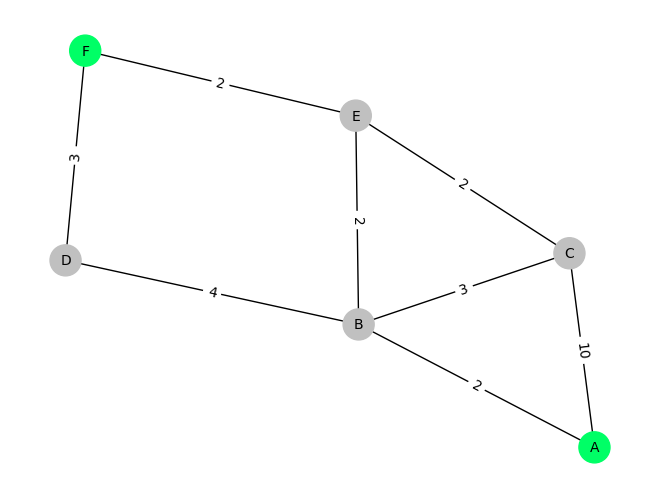

In [3]:
#| label: fig-initial-graph
#| fig-cap: "Graph of locations A-F, with green locations (A,F) being the start- and goal-states. The edges represent the cost of transitioning from one state to another."
#| echo: false
visualize(graph)

# Depth-First search

This first algorithm is very straightforward and works by always expanding the first option that is at the frontier^[The frontier is the border between explored and unexplored states]. In essence, it means that it traverses the search tree like an apple falling to the ground: it does not branch out, it will just go as deep as possible as quickly as possible.

![Conceptual overview of the exploration path that depth-first search is taking.](images/dfs.png){#fig-dfs}


Implementing DFS is very straightforward, as our goal is to always expand the state, which we just found. A common way to implement it is by using a stack.

In [4]:
def dfs(graph, start_node="A", end_node="F"):
  visited = [] # <1>
  stack = [start_node] # <2>

  while len(stack) > 0:
    next_node = stack.pop() # <3>
    print("Visiting", next_node)

    if next_node == end_node:
      visited.append(next_node)
      return visited

    visited.append(next_node)
    stack += list(n for n in graph.neighbors(next_node) if n not in visited and n not in stack) # <4>

1. Array to keep track of visited states. This is used to avoid loops in cyclic graphs.
2. Stack to keep track of the frontier
3. We always explore the latest state that was discovered
4. We won't visit already explored states, as this will be redundant

Let's run this algorithm and see how it performs on our example graph.

Visiting A
Visiting C
Visiting E
Visiting F


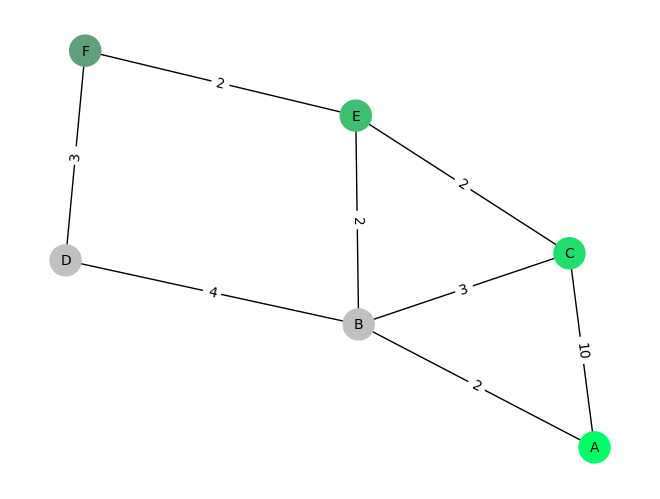

In [5]:
#| label: fig-dfs
#| fig-cap: "Visited states by BFS up to the goal state."
#| echo: false
evaluate(dfs, graph)

DFS does not consider the cost of traversing nodes, and thus it finds a solution, but in this example it's a very costly one. In general, this is a simple graph, and it favors DFS because the solution can be found quickly by going as deep as possible, but there are many cases where the opposite may be the case.

# Breadth-First search

Instead of searching for depth first, which is really a hit-or-miss approach, we can also do the opposite and try to go for breadth first. This means that instead of running in a very narrow direction, we try to explore as many options as possible until we find the solution. As a real-world example, you can imagine breadth-first search like trying out all kinds of interests - e.g. enrolling in courses about art, history, computer science, medicine - and playing out with everything just a bit, until you find yourself getting a job in one of these areas, whereas with a depth-first strategy, you would only focus on becoming an expert a specific area, such as becoming an expert in web development focused on front-end development with react.js and tailwind CSS.

![Conceptual overview of the exploration path that breadth-first search is taking.](images/bfs.png){#fig-dfs}

The implementation of BFS differs very little from the DFS implementation, the only difference being that the frontier is being implemented as a queue, which results in exploring the search tree layer by layer.

In [6]:
def bfs(graph, start_node="A", end_node="F"):
  visited = []
  queue = [start_node] # <2>

  while len(queue) > 0:
    next_node = queue.pop(0) # <2>
    print("Visiting", next_node)

    if next_node == end_node:
      visited.append(next_node)
      return visited

    visited.append(next_node)
    queue += list(n for n in graph.neighbors(next_node) if n not in visited and n not in queue)

1. Queue to keep track of the Frontier
2. In Python, we can implement a queue by popping the first element (instead of the last, as in the stack)

If we run our algorithm, we will see the following result:

Visiting A
Visiting B
Visiting C
Visiting D
Visiting E
Visiting F


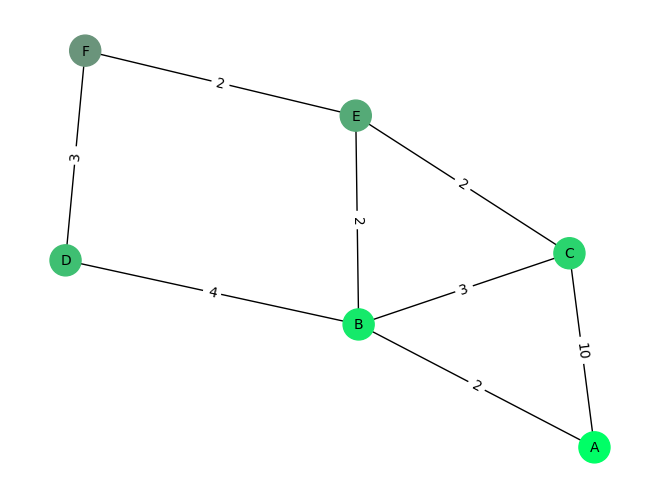

In [7]:
#| label: fig-bfs
#| fig-cap: "Visited states by DFS up to the goal state."
#| echo: false
evaluate(bfs, graph)

Because breadth-first search explores all states from earliest to latest, the algorithm "visits" a lot more nodes than depth first search. In this example, it happens to take longer to find the solution, but there are many cases where breadth first finds a shorter path to the solution than depth first search does. It all depends on the search problem at hand.

# Uniform-Cost search

Until now, the algorithms haven't considered the cost in between nodes, which can be a huge problem. For example, in @fig-dfs we found a solution, but it is a very costly one, as the path from A to C has a cost of 10. To fix this, we can consider the cost of the edges in our algorithm, and the simplest way of choosing a path to our destination is therefore to always pick the next node based on which resulting path has the cheapest accumulative cost. That way, we should always find the cheapest way to the goal. This approach is called Uniform-Cost search and can be implemented in the following way.

In [8]:
def ucs(graph, start_node="A", end_node="F"):
  visited = {} # <1>
  prio_queue = [(0, start_node, None)] # <2>

  while len(prio_queue) > 0:
    print("Queue", prio_queue)
    current_cost, current_node, current_parent = prio_queue.pop(0)

    print("Visiting", current_node)
    visited[current_node] = {"parent": current_parent, "cost": current_cost}

    if current_node == end_node:
      print("Found a solution with total cost of ", current_cost)

      # Reconstruct final path from search-log
      path = [current_node]
      while current_node in visited.keys():
          current_node = visited[current_node]["parent"]
          path.append(current_node)

      # Reverse so it's start -> goal
      path.reverse()
      return path

    neighbors = graph.adj[current_node]
    for expanded_node in neighbors:
      cost = neighbors[expanded_node]["cost"] + current_cost

      # Add a new node only if it hasn't been expanded yet or if it's being
      # reached with a cheaper path.
      if expanded_node in visited.keys():
        if cost > visited[expanded_node]["cost"]: # <3>
          continue

      visited[expanded_node] = {"parent": current_parent, "cost": cost}
      prio_queue.append((cost, expanded_node, current_node))

    # Sort list so it becomes priority queue
    prio_queue.sort()

1. We keep track of the visited states, so we can prevent redundant exploration, but in UCS, we also have to remember the cost of the visit because we could reach the same state from different children in a cyclic graph
2. UCS uses a priority queue, which orders all elements by cost in ascending order
3. To be as efficient as possible, we discard paths that cross a known node and have a higher cost because this will never be the most efficient path anyway.

The implementation of UCS is, again, very similar to BFS and DFS, but it uses a priority queue to keep track of the frontier. Also, we want to return the sequence which describes the cheapest path instead of all the visited nodes as we did before, so we have to reconstruct this path by linking all children of the goal node together, once we found the solution. Let's see what this algorithm does with the example graph.

Queue [(0, 'A', None)]
Visiting A
Queue [(2, 'B', 'A'), (10, 'C', 'A')]
Visiting B
Queue [(4, 'E', 'B'), (5, 'C', 'B'), (6, 'D', 'B'), (10, 'C', 'A')]
Visiting E
Queue [(5, 'C', 'B'), (6, 'D', 'B'), (6, 'F', 'E'), (10, 'C', 'A')]
Visiting C
Queue [(6, 'D', 'B'), (6, 'F', 'E'), (10, 'C', 'A')]
Visiting D
Queue [(6, 'F', 'E'), (10, 'C', 'A')]
Visiting F
Found a solution with total cost of  6


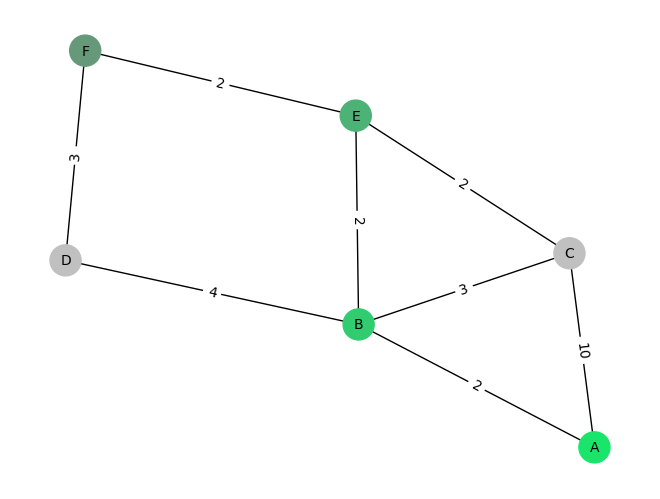

In [9]:
#| label: fig-ucs
#| fig-cap: "Cheapest path to the goal state found by UCS."
#| echo: false
evaluate(ucs, graph)

UCS indeed finds the optimal solution, but it doesn't mean that it's searching in the most efficient way. As you can see in the logs, instead of visiting F directly after choosing E, it first considers C because the path A-B-C has a total cost of 5, while A-B-E-F has a cost of 6. So while UCS will find the cost-optimal solution, it may take a very long time until it gets there.

# Summary

Search is a fundamental problem in artificial intelligence, and it can be divided into many categories. In this article, we explored uninformed search, which is searching without having any clue of the general direction of the goal. BFS, DFS and UCS are three basic algorithms to tackle this problem and they each have their strengths and weaknesses. Depending on the state space one may perform better than the other, but each one has their drawbacks when being measured in space & time-complexity, completeness and cost-optimality. We explored each algorithm by getting an intuition of how it works and by looking at a simple implementation to solve our example problem.